In [24]:
# Data handling and visualization
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and data transformation
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor 


import warnings
warnings.filterwarnings('ignore')

In [2]:
base_path = Path('/kaggle/input/data-science-car-prediction/Data-Science-Car-Prediction/')

file_info = {
    'data_description': 'data_description.csv',
    'occupation': 'occupation.csv',
    'sample_submission': 'sample_submission.csv',
    'train' : 'train_data.csv',
    'label' : 'train_target.csv',
    'test': 'test_data.csv',
    'type_induc' : 'type.csv'
}

for var_name, file_name in file_info.items():
    file_path = base_path / file_name
    globals()[var_name] = pd.read_csv(file_path)

In [18]:
print(f"train shape: {train.shape}")
print(f"target shape: {label.shape}")
print(f"test shape: {test.shape}")
print(f"type shape: {type_induc.shape}")
print(f"occupation shape: {occupation.shape}")
print(f"data description shape: {data_description.shape}")
print(f"sample_submission shape: {sample_submission.shape}")

train shape: (20966, 144)
target shape: (20966, 2)
test shape: (5200, 144)
type shape: (30, 2)
occupation shape: (166, 4)
data description shape: (143, 4)
sample_submission shape: (5200, 2)


In [10]:
train.head(3) #(888, 999 = N/A)

Id  Area          SubDistrict   District  Province  Region  Q1_OccStatus  \
0   0     1              หนองบอน     ประเวศ  กรุงเทพฯ       1             3   
1   1     2  เทศบาลตำบลนครชัยศรี  นครชัยศรี    นครปฐม       2             1   
2   2     1              บางซื่อ    บางซื่อ  กรุงเทพฯ       1             3   

                        Q1_Occ Q1_OccCode Q1_OccInd  ... Line_Level Moblie  \
0           รับจ้างทำความสะอาด        L15         L  ...        888      1   
1                    ขายทอดมัน         D4         D  ...        888      0   
2  รับจ้างขายสลากกินแบ่งรัฐบาล         D4         D  ...        888      1   

  Facebook  Instragram  Tiktok  Youtube  Twitter  OtherApp  OtherAppSpec  \
0        0           0       0        0        0         0           888   
1        0           0       0        0        0         0           888   
2        0           0       0        0        0         0           888   

   NoSocial  
0         0  
1         1  
2         0  

[3 rows x 144 columns]

In [26]:
train.columns

Index(['Id', 'Area', 'SubDistrict', 'District', 'Province', 'Region',
       'Q1_OccStatus', 'Q1_Occ', 'Q1_OccCode', 'Q1_OccInd',
       ...
       'Line_Level', 'Moblie', 'Facebook', 'Instragram', 'Tiktok', 'Youtube',
       'Twitter', 'OtherApp', 'OtherAppSpec', 'NoSocial'],
      dtype='object', length=144)

In [7]:
data_description

Column                               Description     Type  \
0            Area                         พื้นที่เก็บข้อมูล      1-3   
1     SubDistrict                                ตำบล/ แขวง  ข้อความ   
2        District                                อำเภอ/ เขต  ข้อความ   
3        Province                                   จังหวัด  ข้อความ   
4          Region                                       ภาค      1-5   
..            ...                                       ...      ...   
138       Youtube                                5) Youtube      0,1   
139       Twitter                                6) Twitter      0,1   
140      OtherApp                           7) อื่น ๆ ระบุ       0,1   
141  OtherAppSpec                   วิธี/แอปพลิเคชัน อื่น ๆ  ข้อความ   
142      NoSocial  8) ไม่ได้ใช้ทั้งโทรศัพท์และโซเชียลมีเดีย      0,1   

                             Value  
0    1: กรุงเทพ 2: ในเขต 3: นอกเขต  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
..                             ...  
138           0: ไม่เลือก 1: เลือก  
139           0: ไม่เลือก 1: เลือก  
140           0: ไม่เลือก 1: เลือก  
141                            NaN  
142           0: ไม่เลือก 1: เลือก  

[143 rows x 4 columns]

In [16]:
label['Car'].value_counts()

Car
0    11466
1     9500
Name: count, dtype: int64

In [18]:
occupation #รหัสอาชีพ

id                                               type main  \
0     A1  เกษตรกรปลูกข้าว/ พืชไร่ (ไม้ล้มลุก เก็บผลผลิตแ...    A   
1     A2  เกษตรกรพืชสวน ไม้ยืนต้น ไม้ดอกไม้ประดับ พืชผัก...    A   
2     A3  ผู้เลี้ยงสัตว์/ ค้าสัตว์ เช่น โคนม ม้า สัตว์ปี...    A   
3     A4                                     ชาวประมงน้ำจืด    A   
4     A5                                       ชาวประมงทะเล    A   
..   ...                                                ...  ...   
161  P19                                       เย็บเสื้อโหล    P   
162   Q1                                           คนรับใช้    Q   
163   Q2                                     คนสวนประจำบ้าน    Q   
164   Q3                                   คนขับรถประจำบ้าน    Q   
165   Q4           พี่เลี้ยงเด็ก/คนแก่/คนป่วย แม่ครัวในบ้าน    Q   

                                                  list  
0                      เกษตรกรรม การป่าไม้ และการประมง  
1                      เกษตรกรรม การป่าไม้ และการประมง  
2                      เกษตรกรรม การป่าไม้ และการประมง  
3                      เกษตรกรรม การป่าไม้ และการประมง  
4                      เกษตรกรรม การป่าไม้ และการประมง  
..                                                 ...  
161                             กิจกรรมบริการด้านอื่นๆ  
162  กิจกรรมการจ้างงานในครัวเรือนส่วนบุคคล กิจกรรมก...  
163  กิจกรรมการจ้างงานในครัวเรือนส่วนบุคคล กิจกรรมก...  
164  กิจกรรมการจ้างงานในครัวเรือนส่วนบุคคล กิจกรรมก...  
165  กิจกรรมการจ้างงานในครัวเรือนส่วนบุคคล กิจกรรมก...  

[166 rows x 4 columns]

In [20]:
type_induc.head(5) #รูปแบบอุตสาหกรรม

id                                   type
0  BD1                         ผลิตภัณฑ์อาหาร
1  BD2                            เครื่องดื่ม
2  BD3                         ผลิตภัณฑ์ยาสูบ
3  BD4                                 สิ่งทอ
4  BD5  เสื้อผ้าเครื่องแต่งกาย รองเท้า แว่นตา

### processing

In [19]:
train.duplicated().sum()

0

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20966 entries, 0 to 20965
Columns: 144 entries, Id to NoSocial
dtypes: float64(5), int64(107), object(32)
memory usage: 23.0+ MB


In [66]:
for column in train.columns:
    print(column,':',pd.api.types.infer_dtype(train[column]))

Id : integer
Area : integer
SubDistrict : string
District : string
Province : string
Region : integer
Q1_OccStatus : integer
Q1_Occ : string
Q1_OccCode : string
Q1_OccInd : string
Q1_IndBD_1 : string
Q1_IndBD_2 : string
Q1_IndBD_3 : mixed-integer
Q1_Occ_Year : floating
Q1_OCC_A : integer
Q1_OCC_A_Month : integer
Q1_OCC_B : integer
Q1_OCC_B_Num : integer
Q1_OCC_C : integer
Q1_Occ_Have : integer
Q2 : integer
Q2_OccNum : integer
Q2.1_OccStatus : integer
Q2.1_Occ : string
Q2.1_OccCode : string
Q2.1_OccInd : string
Q2.1A : integer
Q2.2_OccStatus : integer
Q2.2_Occ : mixed-integer
Q2.2_OccCode : mixed-integer
Q2.2_OccInd : mixed-integer
Q2.2A : integer
Q3Num : integer
Q3No : integer
Q3.1Year : integer
Q3.1LessYear : integer
Q3.1Month : integer
Q3.2Year : integer
Q3.2LessYear : integer
Q3.2Month : integer
Q3.3Reason : string
Q4_1 : integer
Q4_2 : integer
Q4_3 : integer
Q4_4 : integer
Q4_5 : integer
Q4_6 : integer
Q4_7 : integer
Q4_7Other : string
Q4Most : integer
Q5_1 : integer
Q5_1A : intege

In [74]:
# Transforming mixed data types to single data type
train[column] = train[column].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
train[column][train[column].apply(lambda x: isinstance(x, type))]


# Traverse data frame to detect data types after fix
for column in train.columns:
  print(column,':' , pd.api.types.infer_dtype(train[column]))

Id : integer
Area : integer
SubDistrict : string
District : string
Province : string
Region : integer
Q1_OccStatus : integer
Q1_Occ : string
Q1_OccCode : string
Q1_OccInd : string
Q1_IndBD_1 : string
Q1_IndBD_2 : string
Q1_IndBD_3 : mixed-integer
Q1_Occ_Year : floating
Q1_OCC_A : integer
Q1_OCC_A_Month : integer
Q1_OCC_B : integer
Q1_OCC_B_Num : integer
Q1_OCC_C : integer
Q1_Occ_Have : integer
Q2 : integer
Q2_OccNum : integer
Q2.1_OccStatus : integer
Q2.1_Occ : string
Q2.1_OccCode : string
Q2.1_OccInd : string
Q2.1A : integer
Q2.2_OccStatus : integer
Q2.2_Occ : mixed-integer
Q2.2_OccCode : mixed-integer
Q2.2_OccInd : mixed-integer
Q2.2A : integer
Q3Num : integer
Q3No : integer
Q3.1Year : integer
Q3.1LessYear : integer
Q3.1Month : integer
Q3.2Year : integer
Q3.2LessYear : integer
Q3.2Month : integer
Q3.3Reason : string
Q4_1 : integer
Q4_2 : integer
Q4_3 : integer
Q4_4 : integer
Q4_5 : integer
Q4_6 : integer
Q4_7 : integer
Q4_7Other : string
Q4Most : integer
Q5_1 : integer
Q5_1A : intege

In [132]:
train['Q1_IndBD_3'] = train['Q1_IndBD_3'].replace({888: 'nan', 999: 'nan', '888': 'nan', '999': 'nan'})
train['Q2.2_Occ'] = train['Q2.2_Occ'].replace({888: 'nan', 999: 'nan', '888': 'nan', '999': 'nan'})
train['Q2.2_OccCode'] = train['Q2.2_OccCode'].replace({888: 'nan', 999: 'nan', '888': 'nan', '999': 'nan'})
train['Q2.2_OccInd'] = train['Q2.2_OccInd'].replace({888: 'nan', 999: 'nan', '888': 'nan', '999': 'nan'})
train['Q10.2_5'] = train['Q10.2_5'].replace({888: 'nan', 999: 'nan', '888': 'nan', '999': 'nan'})
train['LiveOther'] = train['LiveOther'].replace({888: 'nan', 999: 'nan', '888': 'nan', '999': 'nan'})


train['Q1_IndBD_3'] = train['Q1_IndBD_3'].astype(object)
train['Q2.2_Occ'] = train['Q2.2_Occ'].astype(object)
train['Q2.2_OccCode'] = train['Q2.2_OccCode'].astype(object)
train['Q2.2_OccInd'] = train['Q2.2_OccInd'].astype(object)
train['Q10.2_5'] = train['Q10.2_5'].astype(object)
train['LiveOther'] = train['LiveOther'].astype(object)

In [133]:
for column in train.columns:
  print(column,':' , pd.api.types.infer_dtype(train[column]))

Id : integer
Area : integer
SubDistrict : string
District : string
Province : string
Region : integer
Q1_OccStatus : integer
Q1_Occ : string
Q1_OccCode : string
Q1_OccInd : string
Q1_IndBD_1 : string
Q1_IndBD_2 : string
Q1_IndBD_3 : string
Q1_Occ_Year : floating
Q1_OCC_A : integer
Q1_OCC_A_Month : integer
Q1_OCC_B : integer
Q1_OCC_B_Num : integer
Q1_OCC_C : integer
Q1_Occ_Have : integer
Q2 : integer
Q2_OccNum : integer
Q2.1_OccStatus : integer
Q2.1_Occ : string
Q2.1_OccCode : string
Q2.1_OccInd : string
Q2.1A : integer
Q2.2_OccStatus : integer
Q2.2_Occ : string
Q2.2_OccCode : string
Q2.2_OccInd : string
Q2.2A : integer
Q3Num : integer
Q3No : integer
Q3.1Year : integer
Q3.1LessYear : integer
Q3.1Month : integer
Q3.2Year : integer
Q3.2LessYear : integer
Q3.2Month : integer
Q3.3Reason : string
Q4_1 : integer
Q4_2 : integer
Q4_3 : integer
Q4_4 : integer
Q4_5 : integer
Q4_6 : integer
Q4_7 : integer
Q4_7Other : string
Q4Most : integer
Q5_1 : integer
Q5_1A : integer
Q5_1B : integer
Q5_2 : int

In [140]:
feature_names = train.drop(columns=['Id']).columns
X = train.drop(columns=['Id'])
y = label['Car'] 

kf = KFold(n_splits=5, shuffle=True, random_state=115)
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (16773, 143)
X_val shape: (4193, 143)
y_train shape: (16773,)
y_val shape: (4193,)


In [21]:
X_train.isnull().sum().sum()

0

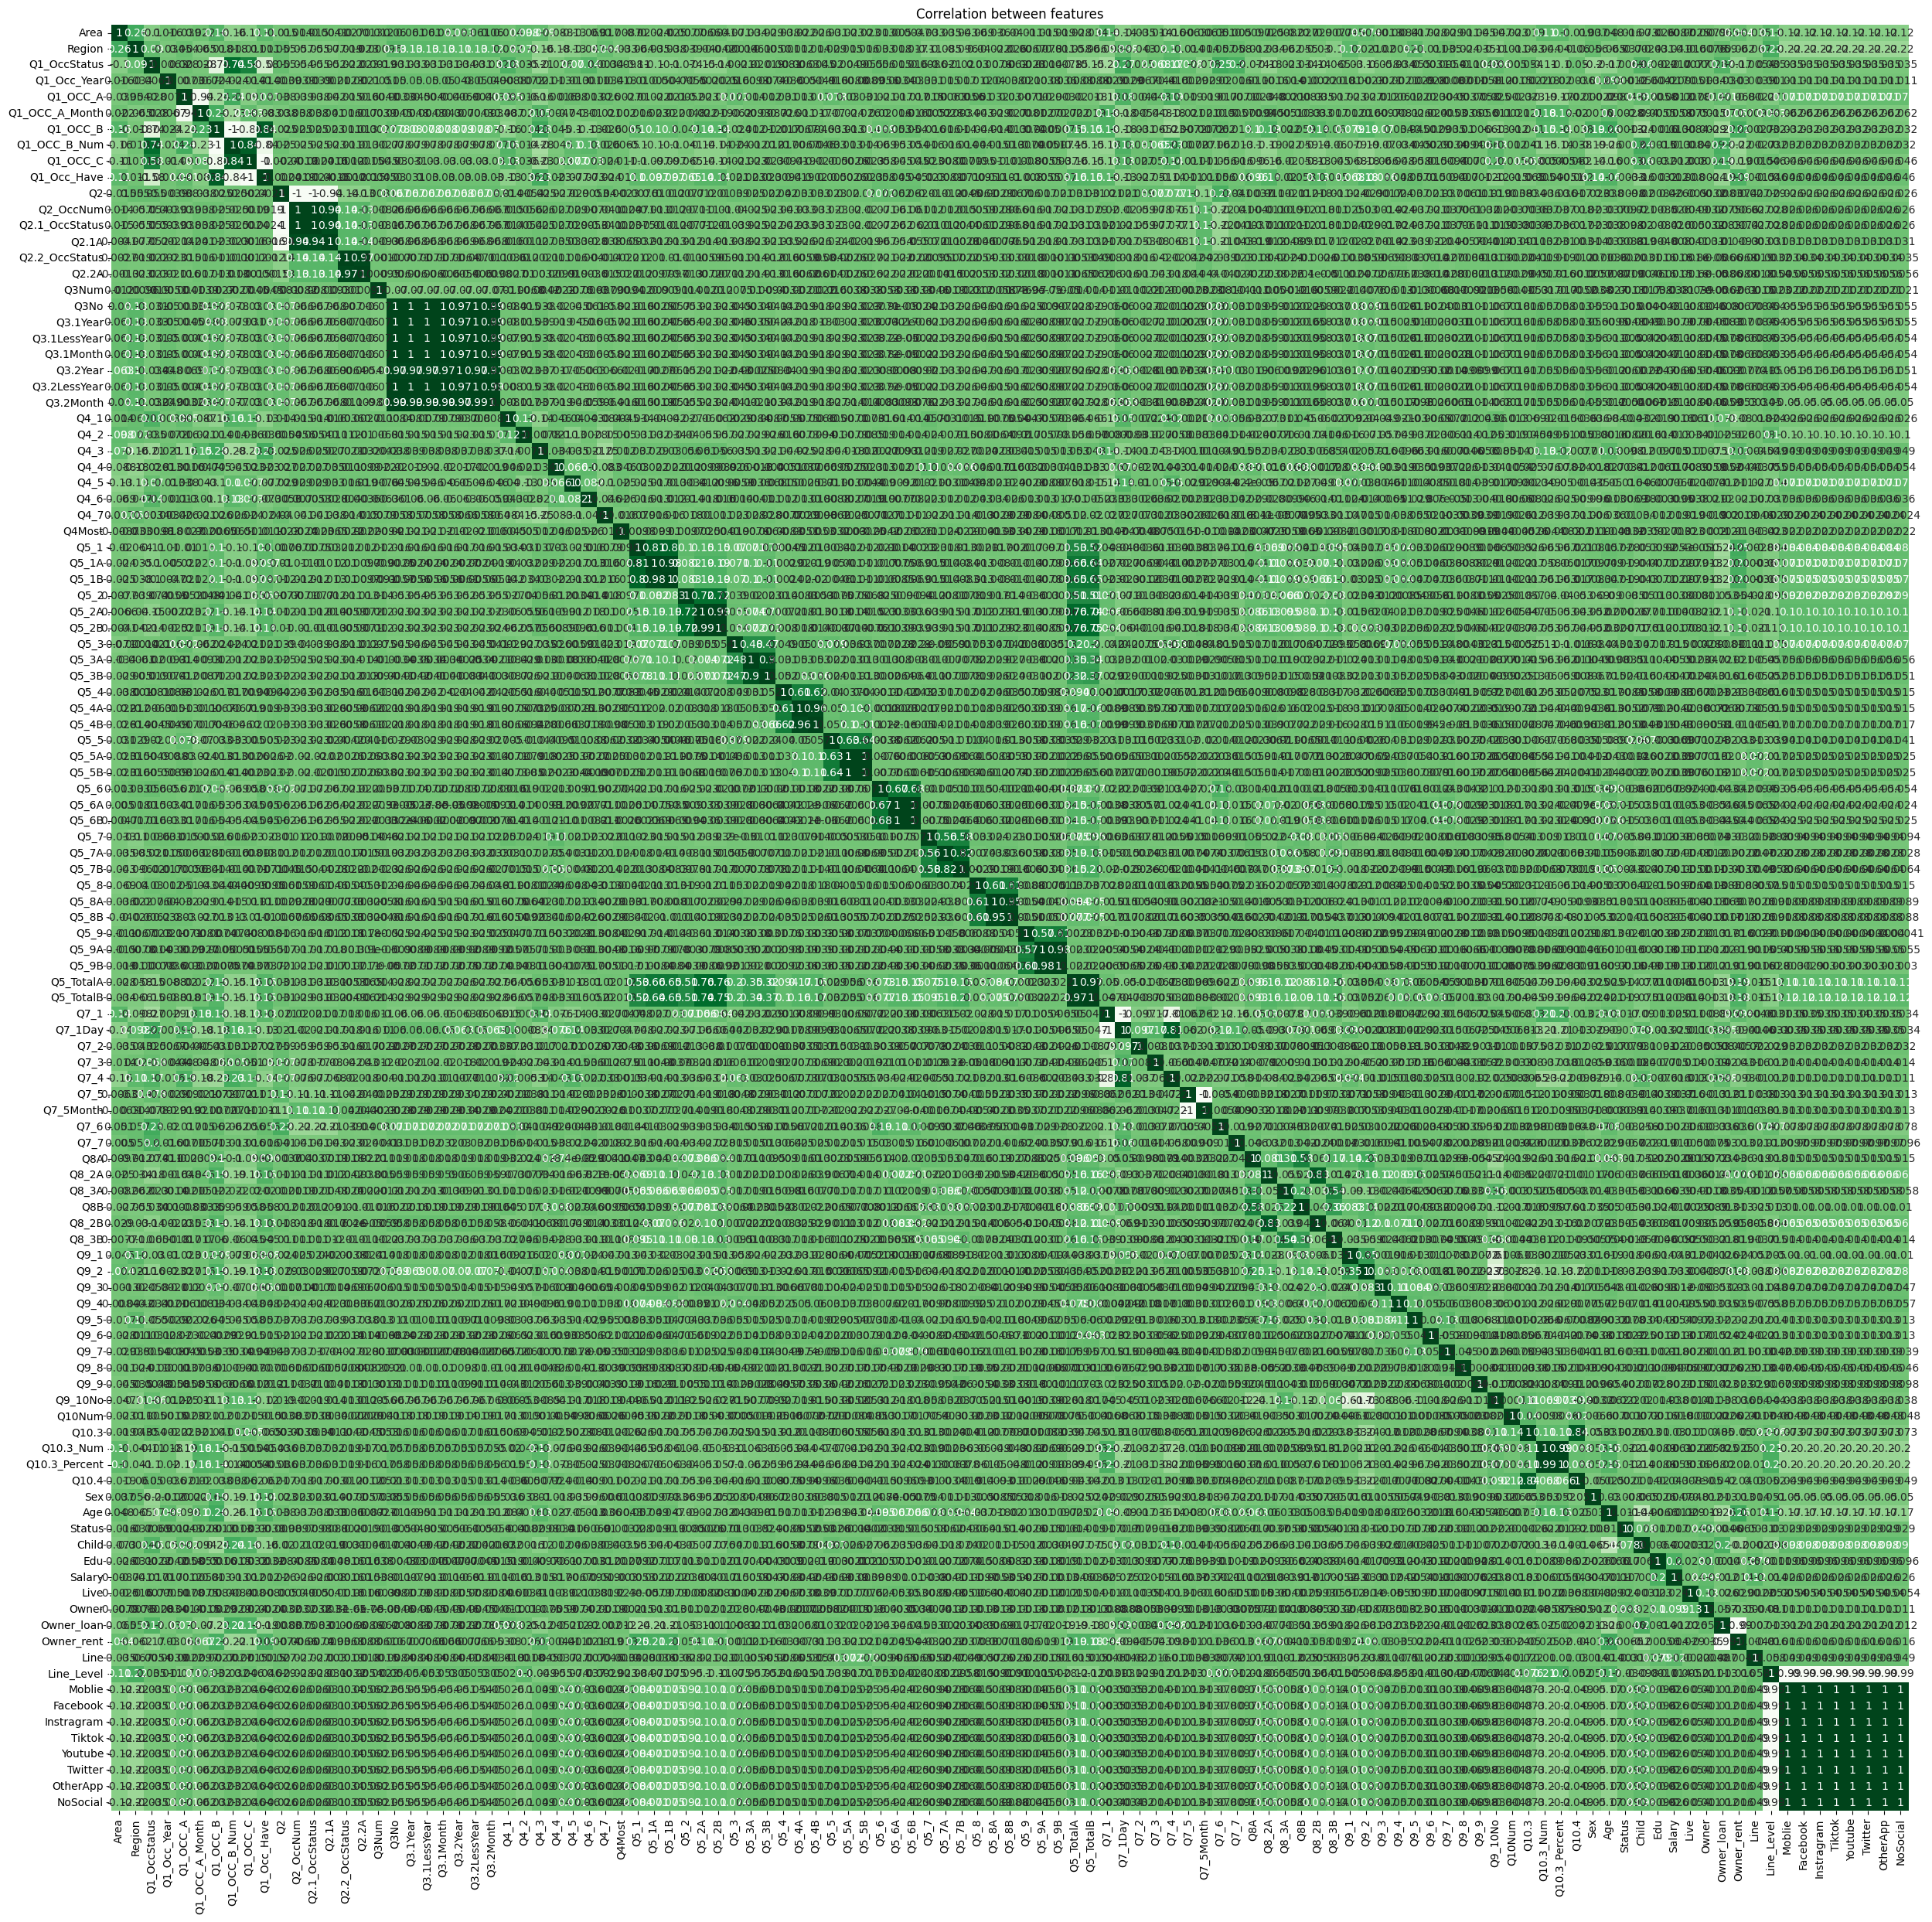

In [141]:
num_data = X_train.select_dtypes(include=np.number).columns.tolist()
cat_data = X_train.select_dtypes(exclude=np.number).columns.tolist()

corr = X_train[num_data].corr()
plt.subplots(1,1, figsize=(30,30))
sns.heatmap(data=corr, cmap ='Greens', annot = corr, cbar=None)
plt.title('Correlation between features')
plt.show()

In [ ]:
# fig, ax = plt.subplots(len(num_data), 1, figsize=(6, 100))
# for axs, feature in zip(ax, num_data):
#     X_train[[feature]].boxplot(ax=axs)

In [39]:
 train.select_dtypes(['int', 'float']).columns

Index(['Id', 'Area', 'Region', 'Q1_OccStatus', 'Q1_Occ_Year', 'Q1_OCC_A',
       'Q1_OCC_A_Month', 'Q1_OCC_B', 'Q1_OCC_B_Num', 'Q1_OCC_C',
       ...
       'Line', 'Line_Level', 'Moblie', 'Facebook', 'Instragram', 'Tiktok',
       'Youtube', 'Twitter', 'OtherApp', 'NoSocial'],
      dtype='object', length=112)

In [30]:
cat_columns = train.select_dtypes(['object']).columns
cat_columns

Index(['SubDistrict', 'District', 'Province', 'Q1_Occ', 'Q1_OccCode',
       'Q1_OccInd', 'Q1_IndBD_1', 'Q1_IndBD_2', 'Q1_IndBD_3', 'Q2.1_Occ',
       'Q2.1_OccCode', 'Q2.1_OccInd', 'Q2.2_Occ', 'Q2.2_OccCode',
       'Q2.2_OccInd', 'Q3.3Reason', 'Q4_7Other', 'Q5_9Other', 'Q9_9Other',
       'Q10.1_1', 'Q10.1_2', 'Q10.1_3', 'Q10.1_4', 'Q10.1_5', 'Q10.2_1',
       'Q10.2_2', 'Q10.2_3', 'Q10.2_4', 'Q10.2_5', 'LiveOther', 'AssetOther',
       'OtherAppSpec'],
      dtype='object')

In [134]:
# 2.preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

In [135]:
def process_df(df):    
    #1、Handling null values 
    df=df.dropna()
    
    #2、create y value by using "diagnosis", convert to int type 
    target=label['Car'] 
    df=train.drop(columns=['Id'])
    
    #3、Create the training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size = 0.2, 
                                                    random_state=100,stratify=target)
    
    #4、Obtaining continuous variable 
    numaric_columns=list(df.select_dtypes(include=np.number).columns)
    print("Numaric columns ("+str(len(numaric_columns))+") :",", ".join(numaric_columns))
    
    #5、Obtaining discrete variables 
    cat_columns=df.select_dtypes(include=['object']).columns.tolist()
    print("Categorical columns ("+str(len(cat_columns))+") :",", ".join(cat_columns))
    
    
    #6、Using continuous variable training data 
    X_train_n=X_train[numaric_columns].copy()
    X_test_n=X_test[numaric_columns].copy()
    scaler = MinMaxScaler()
    X_train_n_index = X_train_n.index
    X_test_n_index = X_test_n.index
    
    X_train_n = scaler.fit_transform(X_train_n)
    X_train_n = pd.DataFrame(X_train_n,index=X_train_n_index,columns = numaric_columns)
    
    X_test_n = scaler.transform(X_test_n)
    X_test_n = pd.DataFrame(X_test_n,index=X_test_n_index,columns = numaric_columns)

    #7、Using discrete variable training data 
    X_train_c=X_train[cat_columns]
    X_test_c=X_test[cat_columns]
                               
    #8、Ordinal label processing for discrete variables 
    encoder=OrdinalEncoder()
    X_train_c = encoder.fit_transform(X_train_c)
    
    X_train_c=pd.DataFrame(X_train_c,index=X_train_n.index)
    X_test_c = encoder.transform(X_test_c)
    X_test_c=pd.DataFrame(X_test_c,index=X_test_n.index)
    
    #9、Merge together
    for i,column in enumerate(X_train_c.columns):
        X_train_n["cat_"+str(i+1)]=X_train_c[column]
        X_test_n["cat_"+str(i+1)]=X_test_c[column]

    return X_train_n, X_test_n, y_train, y_test

In [136]:
X_train, X_test, y_train, y_test = process_df(train)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Numaric columns (111) : Area, Region, Q1_OccStatus, Q1_Occ_Year, Q1_OCC_A, Q1_OCC_A_Month, Q1_OCC_B, Q1_OCC_B_Num, Q1_OCC_C, Q1_Occ_Have, Q2, Q2_OccNum, Q2.1_OccStatus, Q2.1A, Q2.2_OccStatus, Q2.2A, Q3Num, Q3No, Q3.1Year, Q3.1LessYear, Q3.1Month, Q3.2Year, Q3.2LessYear, Q3.2Month, Q4_1, Q4_2, Q4_3, Q4_4, Q4_5, Q4_6, Q4_7, Q4Most, Q5_1, Q5_1A, Q5_1B, Q5_2, Q5_2A, Q5_2B, Q5_3, Q5_3A, Q5_3B, Q5_4, Q5_4A, Q5_4B, Q5_5, Q5_5A, Q5_5B, Q5_6, Q5_6A, Q5_6B, Q5_7, Q5_7A, Q5_7B, Q5_8, Q5_8A, Q5_8B, Q5_9, Q5_9A, Q5_9B, Q5_TotalA, Q5_TotalB, Q7_1, Q7_1Day, Q7_2, Q7_3, Q7_4, Q7_5, Q7_5Month, Q7_6, Q7_7, Q8A, Q8_2A, Q8_3A, Q8B, Q8_2B, Q8_3B, Q9_1, Q9_2, Q9_3, Q9_4, Q9_5, Q9_6, Q9_7, Q9_8, Q9_9, Q9_10No, Q10Num, Q10.3, Q10.3_Num, Q10.3_Percent, Q10.4, Sex, Age, Status, Child, Edu, Salary, Live, Owner, Owner_loan, Owner_rent, Line, Line_Level, Moblie, Facebook, Instragram, Tiktok, Youtube, Twitter, OtherApp, NoSocial
Categorical columns (32) : SubDistrict, District, Province, Q1_Occ, Q1_OccCode, Q1_OccI

ValueError: Found unknown categories ['ลูกจ้างร้านซักรีด', 'ขายมัน+กล้วยย่าง', 'ขายขนมกล้วยปิ้ง', 'ขายเสื้อผ้าหน้าร้าน ออนไลน์', 'พนักงานรับอาหาร', 'รับจ้างร้านขายทั่วไป', 'คนงานสวนยาง', 'ขายน้ำมันเชื้อเพลิง', 'ช่างประปา', 'เลี้ยงปลาสวยงาม', 'รับจ้างร้านตักกับข้าว', 'รับจ้างร้านขายหอมกระเทียม', 'รับทำกรอบพระ', 'ขายรูปภาพ', 'ขายขนมทาโกะยากิ', 'ขายเครื่องมือทางการเกษตร', 'ขายผัดไทยโบราณ', 'เกษตรกรสวนยางพารา', 'ออกทะเลหาปลา', 'รับจ้างทำก่อสร้าง', 'ทำสวนพริก', 'รับจ้างขายดอกไม้ธูปเทียน', 'รับจ้างร้านขายปลาหมึกทอด', 'ขายเกาเหลาอาหาร', 'ขายน้ำตาลสดในตลาดแผง', 'รับจ้างขายมะพร้าว', 'ร้านรับทำกรอบพระ', 'ขายยำ ลาบ', 'ร้านฟิตเนส', 'ขายอุปกรณ์ซ่อมทรศัพท์มือถือ', 'ช่างกลึง', 'ขายกระเทียม/ฟักทอง', 'นายหน้าที่ดิน', 'ขับรถดูแล', 'ทำฟาร์มหอย', 'ขายปลาดุกหมูปิ้ง', 'ขายไก่ป๊อบ', 'ร้านจัดดอกไม้', 'ช่างยนต์', 'ดูแลร้านกล้องวงจรปิด', 'รับจ้างตามงานปาเป้า', 'รับจ้างขัดยีนส์(กางเกงยีนส์)', 'ทำขนมลาขาย', 'รับสอนพิเศษ', 'รับจ้างร้านขายน้ำมะพร้าวปั่น', 'ขายข้าวสวย+ข้าวเหนียว', 'ขายถั่วข้าวโพดต้ม', 'รับจ้างร้านขายทองคำ', 'รับจ้างร้านขายอุปกรณ์ตัดต้นไม้,เมล็ดพันธุ์พืช', 'ขายของแข็ง', 'รับจ้างซ่อมเบาะรถ', 'พนักงานต้อนรับโรงแรม', 'รับจ้างขายอุปกรณ์โทรศัพท์มือถือ', 'ขายลำไย ผลไม้ตามฤดูกาล', 'แม่ครัวในบ้าน', 'ขายบับเบิ้ล', 'พนักงานดูแลสถานที่จอดรถ', 'พนง.ขายน้ำผลไม้ปั่น', 'รับจ้างขายแหวน', 'นวดไทย', 'สามล้อรับจ้าง', 'รับจ้างร้านขายวุ้นมะพร้าว', 'ขายน้ำผลไม้+น้ำเปล่า', 'ขายหอยเชลล์', 'โรงงานปอกกุ้ง', 'พนง.ร้านนวด', 'ขายของชำ ', 'รับจ้างใส่ถ่านนาฬิกา', 'เย็บผ้า,ช่างเย็บผ้า', 'ขายของชำรวมทุกชนิด', 'รับจ้างร้านขายเครื่องประดับ', 'ขายหูหมู', 'รับจ้างร้าขายนอาหารตามสั่ง', 'รับจ้างออกเรือหาปลา', 'รับจ้างเสียบหมูปิ้ง', 'รับจ้างขายแฮมเบอร์เกอร์', 'ทำตู้เกมส์', 'คุมคนงาน', 'ติดตั้งคอมพิวเตอร์', 'พนักงานขับรถส่งปลา', 'พนง.ร้าน7-11', 'รับจ้างร้านขายถุงเท้า', 'ขายน็อต สรู ออนไลน์', 'ส่งน้ำแข็ง', 'ทำเฟอร์นิเจอร์', 'ขายยำรวม', 'ขายพิซซ่าทาร์ตไข่', 'ขายของเช้า', 'ขายส่งผัก', 'คัดแยกกุ้ง', 'ขายพริกหอมกระเทียม', 'รับจ้างขายกุ้งอบวุ้นเส้น', 'พนักงานปั๊ม', 'ให้เช่าเต๊นซ์', 'ขับรถขนสินค้า', 'ขายส้มตำไก่ทอด', 'อาหารแมว', 'ขายทุเรียนแกะ', 'ให้เช่ารถตู้', 'รับจ้างขายอาหารเสริม', 'รับจ้างขายตั๋วรถโดยสาร', 'ขายเห็ดย่าง', 'ขายรถ', 'ลูกจ้างรถไฟพนักงานทำความสะอาด', 'ร้านขายปลาทอดหน้าตลาด', 'ขับรถ Flash', 'ขายยางรถยนต์', 'ขายโดนัท,น้ำ', 'กรรมกรก่อสร้าง', 'ขายไส้กรอกอีสานทอด', 'ขายแคปหมูทอด', 'ทำขนมทองม้วนส่งขาย', 'รับจ้างก่อสร้าง ช่างปูน', 'ขายลูกชิ้น/ไส้กรอก', 'ลูกจ้างร้านขายส้มตำ', 'ร้านช่างซ่อมคอมพิวเตอร์', 'รับจ้างภาครัฐ', 'เย็บผ้า  ตัดเสื้อ', 'ติดตั้งแอร์', 'รับจ้างขายอุปกรณ์อิเล็คทรอนิคส์', 'นักการภารโรง', 'ขายยำปูม้า', 'ขายน้ำแฟรนไซส์', 'ขายลำไย', 'ขายขนมปังกรอบใส่ถุง', 'ขายไก่ย่าง ตับย่าง', 'รับจ้างเย็บผ้าซ่อมแซมผ้า', 'บริการอาบน้ำสุนัข', 'รับจ้างร้านขายปุ้ย', 'ขายทุกอย่าง 20 บาท', 'ขายทอดมันปิ้ง', 'ลูกจ้างร้านขายไอติม', 'รับจ้างร้านขายพวงมาลัย/ดอกไม้', 'เก็บค่าเข้าห้องน้ำ', 'ไกด์ทัวร์', 'พนักงานขาย อาหาร', 'ขายขนม สาหร่าย', 'รับพิมพ์งาน', 'รับเหมาอลูมิเนียม', 'บริการเต้นท์เช่า', 'ขายหมูแดดเดียวมีแผง', 'เหมาเชื่อมโลหะ', 'รับจ้างร้านช่างอะไหล่', 'ขายบะหมี่คลุก', 'ขายจิ้มจุ่ม หมูกะทะ', 'รับส่งเอกสาร', 'รับจ้างคีย์เอกสาร', 'รับสักคิ้ว', 'รับจ้างหิ้วของ', 'ขายอาหารซีฟู้ด', 'พนักงานกองพัสดุ', 'รับจ้างร้านขายน้ำมันนวด', 'แม่บ้านฟิตเนส', 'ร้านปั้มกุญแจ', 'รับซักผ้า', 'พนง.ร้านวัสดุก่อสร้าง', 'ขายน้ำดื่ม,น้ำอัดลม', 'รับจ้าง(ช่างเชื่อมเหล็ก)', 'ตัดขน/แต่งขนสัตว์', 'รับจ้างขายกล้วยทอด', 'ขายเฟอนิเจอร์', 'รับจ้างเก็บปาล์ม', 'ขายของชำหลายชนิด', 'รับจ้างร้านขายไส้ย่าง', 'ขายน้ำมันมะพร้าว', 'ร้านขายอาหารชมจันทร์', 'ปลูกผลไม้', 'ขายนาฬิกา/แว่นตา', 'เย็บผ้าที่บ้าน', 'ขายหอยนางรม', 'ขายสาคูไส้หมู/ข้าวเกรียบปากหม้อ', 'ขายหนังสือพิมพ์และเครื่องดื่ม', 'ขายข้าวสวยถ้วย', 'ขายก๋วยเตี๋ยว/ข้าวแกง', 'ตัดเสื้อกางเกง', 'ขายมะนาวสด', 'รับจ้างเฝ้าร้านเกมส์', 'ดูแลห้องเช่า', 'ทำสวนลำไย', 'ทำความสะอาด ล้างจาน', 'รับจ้างเขียงหมู', 'รับจ้างร้านขายหมูแผ่น', 'รับจ้างร้านขายปลาทูนึ่ง', 'พนจ.จั้งฟู้ด', 'ขายผัก/ปลาทู', 'รับจ้างขายอุปกรณ์อิเล็กทรอนิกส์', 'รับจ้างร้านขายนมสด', 'เปิดร้านนวดเพื่อสุขภาพ', 'อสม.สาธารณสุข', 'ขายขนมไข่นกกระทา,มันทอด,เผือกทอด', 'ขายยางรถ', 'ขายมะพร้าวอ่อน', 'ขายเครื่องดื่มน้ำสมุนไพร', 'โรงงานน้ำดื่ม', 'เปิดบริษัทจำหน่าย ติดตั้งแอร์', 'รับจ้างร้านน้ำชากาแฟ', 'แม่ครัวของวัด', 'ขายหน่อไม้ดอง', 'ขายเห็ดเข็มทอง', 'รับติดตั้งเครื่องเสียง', 'รับซ่อมบ้าน', 'ทำฟันปลอม', 'รับตัดชุด', 'ขายไส้กรอกอีสานย่าง', 'ส่งอาหารสด', 'ขายปุ๋ยทางเกษตร', 'รับซื้อมังคุด', 'ลูกจ้างร้านขายเคสโทรศัพท์', 'โรงงานผลิตอลูมิเนียม', 'ขายคางกุ้งย้าง', 'ขายของใช้เบ็ดเตล็ดทุกอย่าง 20 บาท', 'รับจ้างโยธา', 'สอนดนตรี', 'รับจ้างขายพริกแกงสด', 'ขายขนมเค้กขนมอบแห้ง', 'ขายเครื่องดื่มโค้ก/เป๊ปซี่', 'ขายปลาทูทอด', 'ปลูกไร่ข้าวโพด', 'ของชำทุกชนิด', 'ขายทาร์ตไข่', 'ซ่อมอุปกรณ์โทรศัพท์มือถือ', 'ขายหมูกรอบ', 'ทำเอกสารแรงงานต่างด้าว', 'เกษตรการปลูกผัก', 'รับจ้างร้านเกมส์', 'รับเหมาต่อเติม', 'ฟาร์มหมา', 'ขายชุดเสื้อผ้า', 'ร้านตัดเย็บเสื้อผ้า', 'รับจ้างขับรถส่งนักเรียน', 'รับจ้างขายที่นอน', 'รับทำเบาะ', 'พนักงานกรมปศุสัตว์', 'รับจ้างรับส่งของอุปโภคบริโภค', 'ขายไข่ไก่ ไข่เป็ด', 'ขายเบอร์เกอร์ไก่', 'เก็บขยะเทศบาล', 'ขายขนมแพนเค้ก', 'รับจ้างร้านรองเท้ายาง', 'รับจ้างร้านจักรยนต์', 'ขายขนมดอกบัว', 'ติดฟิล์มกรองแสง', 'ทำงานเซ็ลทรัล ขับรถ', 'ขายเช่า-ซื้อชุด', 'ขายข้าวหน้าเป็ด', 'ขายเตาแก๊ส', 'ขายปลาสด น้ำอัดลม', 'ประมงน้ำเค็ม', 'ขายแหนมหมูยอ', 'พนักงานร้านซูซิ', 'ขายเฟรนฟราย เครื่องดื่มชง', 'ธุรกิจส่วนตัว', 'ขายเป็ดหมูพะโล้', 'ขายซูชิ/ขายสลัด', 'รับจ้างขับรถตู้ส่งนักเรียน', 'รับจ้างร้านขายต้นไม้', 'ร้านซ่อมขายโทรศัพท์มือถือ', 'ปลูกผักส่ง', 'ขายข้าวยำ', 'รับจ้างขับรถแบคโฮ', 'รับจ้างขนสุกร', 'ขายมะพร้าว/ขนม', 'โรงงานขายขนมจีน', 'รับจ้างชลประทาน', 'รับจ้างล้างแอร์', 'พนักงานเรียงสินค้า', 'ขายผลไม้แช่อิ่ม', 'ขายข้าวโพดสดต้ม', 'ทำนา ปลูกข้าว', 'รับจ้างคัดกุ้ง', 'รับจ้างขายพริกแห้งและของแห้งทั่วไป', 'สถาปนิก', 'ขายครกไม้', 'รับจ้างขายเหล้า/เบียร์', 'รับจ้างซักรีดเสื้อผ้า', 'ขายกระเป๋าใส่เงิน', 'เกษตรกรปลูกผัก', 'ขายกางเกงมีแผง', 'รับจ้างงานก่อสร้างทำถนน', 'ขายเครื่องประดับมงคล', 'ขายของฝากกุนเชียง', 'รปภ.เทศบาล', 'รับจ้างทำความสะอาดตามบ้าน', 'เสมียนโรงสีข้าว', 'ทำโลโก้', 'แผงขายรองเท้า', 'พนักงานนวดแผนไทย', 'ขายข้าวเหนียวปิ้ง', 'วิทยากรอิสระ', 'รับจ้างขายปลาทูเค็ม', 'รับจ้างรับส่งของ', 'พนง.ชั่วคราวซ่อมโทรศัพท์มือถือ', 'รับจ้างงขายชุดนักศึกษา', 'รับจ้างขายนมเปรี้ยวตราดีไลท์', 'ขายน้ำพริกผักจิ้ม', 'ร้านสักคิ้ว', 'รับจ้างขายน้ำหวาน', 'ขายเป็ดต้ม', 'ขายหมุสด', 'พนักงานขายไก่ทอด', 'ครูสอนว่ายน้ำ', 'รับจ้างดูบ่อกุ้ง', 'ตัดสติ๊กเกอร์ติดรถ', 'รับทำวีซ่า', 'แม่บ้านอัตราจ้าง', 'ขายหมึกสด', 'ขายท่อน้ำ', 'รับจ้างจัดสวน', 'รับจ้างขายเกาเหลา', 'รับจ้างร้านขายเป็ดพะโล้', 'ลูกจ้างร้านขายก๋วยเตี๋ยว', 'ร้านอะไหล่รถ', 'ซื้อ-ขายของเก่า', 'ขายโตเกียว แพนเค้ก', 'ขายเสื้อผ้ามือสสอง', 'เลี้ยงปลาดุก', 'ทำบายศรี', 'ปลูกขายต้นไม้', 'ขับรถ', 'รับทำป้าย', 'ขายกรอบพระ', 'ขายผ้าเช็ดตัว', 'ช่างทำฝ้า', 'ตัดแว่น', 'ขายผักปลอดสาร', 'ขายเนื้อทอดข้าวเหนียว', 'ขายปิ้งย่าง', 'ขายไก่อบ', 'ขายของปลีก', 'นักเล่นกล', 'ขายเปาะเปี๊ยะ', 'รับจ้างร้านขายเรซิ่น', 'รับจ้างเข็นผัก', 'รับจ้างแผงผัก', 'รับจ้างรายวันร้านขายกาแฟ', 'ทำรางน้ำ', 'เจ้ามือหวย', 'ขายร้านกาแฟสด', 'รีวิวสินค้า', 'ขายตับหมูปิ้ง', 'รับจัดเลี้ยงอาหารในงาน', 'ขายไก่สด/กับข้าว/โดนัท', 'รับจ้างขายหนังสือพิมพ์', 'ครูพี่เลี้ยงเอกชน', 'รับจ้างส่งสินค้า', 'รับจ้างขายของชำเบ็ดเตล็ด', 'ขายหมูแผ่นทอด', 'ขายหมี่กรอบ ขายน้ำ', 'ช่างLED', 'ขับรถรับจ้างอิสระ', 'รับจ้างตรวจสภาพรถ', 'ขายเส้นก๋วยเตี๋ยวลูกชิ้น', 'ขายหมูยอราคาส่ง', 'ขับรถแบคโฮ', 'รับจ้างขายปลาน้ำจืด', 'รับจ้างคนงานเขียงหมู', 'ขายเนื้อหมู/ขายไข่ไก่', 'ขายถุงเท้าเป็นแผงในตลาด', 'ร้านขายกาแฟน้ำปั่น', 'ลูกจ้างในร้านอาหาร', 'ขายบ้านไม้เก่า', 'ขายกาแฟ  น้ำปั่น', 'ขายขนมไข่มุก', 'พนง.ห้างแผนกสต็อก', 'รับจ้างรับเหมาไฟฟ้า', 'ขายเสื้อผ้าออนไลน์และมีหน้าร้าน', 'รับจ้างขายกุ้ง', 'วิศวกรอิสระ', 'ครูช่วยสอน', 'รับจ้างร้านคอมพิวเตอร์', 'ขายใบพัด', 'ขายกับข้าวถุงแกงถุง', 'รับจ้างร้านขายของชำทั่วไป', 'ช่างทำกรอบพระ', 'รับปั๊มกุญแจ', 'ขายชาบูเสียบไม้', 'ขายเสื้อผ้าเด็กออนไลน์', 'รับจ้างนวด', 'แคชเกมส์', 'ขายนมเปรี้ยว', 'ร้านขายอุปกรณ์ก่อสร้าง', 'ขายผลไม้เมล่อน', 'ดูแลโต๊ะสนุก', 'เก็บขยะขาย', 'รับติดตั้งไฟฟ้า', 'ขายแกงส้มแป๊ะซะ', 'ขายลูกชื้นทอด', 'ขับรถห้องเย็นส่งอาหาร', 'ขายกระเป๋าสาน', 'แม่ค้าออนไลน์ อาหาร', 'ทำเบาะรถ', 'ร้านขายรองเท้า', 'ขายน้ำพริกหนุ่ม', 'ช่างทำทอง', 'ผลิตของเล่นเด็ก', 'ขายผักตามฤดูกาล', 'ขายฝักบัว', 'ติดฟิล์มรถยนต์', 'พนง.โรงเรียนสอนขี่ม้า', 'ขายอาหารสดกุ้งปลาหมึก', 'รับจ้างขายกะหรี่ปั๊บ', 'ขายสติ๊กเกอร์', 'ขายเสื้อใน', 'ขายไส้อั่ว/ขนุนต้ม', 'รับจ้างขายกุ้งย่าง', 'รับเหมามุงหลังคา', 'ร้านติดกล้องรถยนต์', 'ผู้ช่วยคุมงานเอกสาร', 'มักคุเทศก์', 'ขายปลีกหลอดไฟ', 'ขายชากาแฟ', 'ขายผลไม้รถพุ่มพวง', 'ร้านรับส่งของ', 'ขายอาหารทั่วไป', 'รับจ้างขายถั่วต้ม', 'ขายหมูยอสด', 'รับจ้างทำไฟฟ้าตามบ้าน', 'รับจ้างขายหมี่โคราช', 'ขายเช่าพระ', 'ลูกจ้างร้านตามสั่ง', 'ตัดขนสุนัข', 'เด็กรถ', 'ขายสร้อยกับกรอบพระ', 'รับจ้างขายของ อุปกรณ์ก่อสร้าง ', 'รับเหมาไฟฟ้า', 'ขายหอย', 'ขายอาหารตามสั่งและเครื่องดื่ม', 'พนง.ส่งของ', 'ขายไก่บ้าน', 'อะไหล่รถ', 'รับจ้างขายผักสดมีแผง', 'ขับ Get', 'ขายข้าวปุ้นน้ำแจ่ว', 'รับจ้างขนเหล็ก', 'รับจ้างขายผ้าฝ้ายทอมือ', 'รถเข็นขายขนมบ้าบิ่น', 'พนักงานมินิมาร์ท  ขายอาหารและเครื่องดื่ม', 'ลูกจ้างร้านลาบอีสาน', 'รับจ้างเด็ดพริก', 'ขายน้ำปลาร้า/ขนม', 'ขายฟิล์มเคสโทรศัพท์', 'รับจ้างลาล่ามูฟ', 'รับจ้างขายปลาไหล', 'ช่างเหล็ก ช่างสี', 'นายหนาเช่าบ้าน ซื้อขายบ้าน', 'พนักงานทำเอกสาร', 'ปลูกยาสูบ', 'การตลาดออนไลน์', 'รับจ้างขายเฟอร์นิเจอร์', 'ขายกบ/ปลาสด', 'ผู้ช่วยครู', 'ซ่อมรถแท็กซี่', 'ร้านขายผลไม้', 'รับจ้างขับรถให้พนักงาน', 'ขายขนมตาล น้ำส้มคั้น ปลาทอด', 'ลูกจ้างเลี้ยงไก่', 'ขายแหนมใบตอง', 'ขายอะไหล่รถ', 'รับจ้างทำป้ายโฆษณา', 'พนักงานร้านขายอาหารแช่แข็ง', 'แผงเช่าพระเครื่อง', 'ขายน้ำหอมตลาดนัด', 'พนักงานปั้มน้ำ', 'ลูกจ้างส่งของ', 'ขายฟักทอง/แตงไทย/มันม่วง', 'ขายปลาทับทิม', 'ขายกระปุกออมสินไม้สัก', 'ขายหอยแคงลวก', 'เย็บผ้าซ่อมผ้า', 'รปภ.โรงงาน', 'รับจ้างขายของส่ง', 'ร้านอุปกรณ์การเรียน', 'ซ่อมเสื้อผ้า/รองเท้า', 'ขับรถเทศบาล', 'เปิดร้านนวดแผนโบราณ', 'ขายใส้กรอกอีสาน', 'ขายลุกชิ้น', 'รับจ้างดูแลผู้ป่วย', 'ขายเครื่องครัว/พลาสติก', 'ขายน้ำเต้าหู้ และปาท่องโก๋', 'รับจ้างทำสเตนเลส', 'รับจ้างทำเฟอร์นิเจอร์', 'รับจ้างขับรถร้านขายของ', 'พนักงานร้านโทรศัพท์', 'รับจ้างคลินิก', 'รับจ้างร้านขายเสื้อกันฝน/เครื่องดื่ม', 'ทำไร่มัน', 'ขายส้มตำ+ปลา', 'ขายปูจี๊ด', 'พนักงานขายมอเตอร์ไซค์', 'ร้านซ่อมรถยนต์', 'เลี้ยงสัตว์', 'ขายหอยจ๊อ/เปาะเปี๊ยะทอด', 'ขายต้มแซ่บกระดูกอ่อน', 'ขายของทะเลแห้ง', 'ทำของชำร่วย', 'รับจ้างขายหินทราย', 'ขายน้ำ/ขายลูกชิ้น', 'รับจ้างร้านขายกับข้าว', 'ขายหมูอบโอ่ง', 'ช่างสี รับจ้างทางสี', 'แม่บ้านรับจ้าง', 'ร้านขายไม้นวดเท้า/ไม้แขวนผ้า', 'ขายไก่ย่าง/ข้าวต้มมัด', 'ขายอาหารบะหมี่เกี๊ยว', 'รับจ้างขาย', 'ขายสลากกินแบ่งรัฐบาล ขายไก่สด', 'ขายน้ำเปํปซี่+น้ำดื่ม', 'รับจ้างร้านขายมะพร้าว', 'รับจ้างปักเสื้อ', 'รับจ้างขายทั่วไป', 'ขายเสื้อรับปัก', 'ตู้กาแฟหยอดเหรียญอัตโนมัติ', 'รับจ้างต่อเติมอลูมิเนียม กระจก', 'ขายกับข้าวในตลาด', 'รับส่งนักเรียน', 'FMT ฝ่ายผลิต', 'ขายเครื่องดื่มสตอเบอรี่โยเกิต', 'ขายนมเปรี้ยวบีทาเก้น', 'ขายจักรยานมือสอง', 'ขายข้าวหุงสุก', 'ขายยาฆ่าแมลง', 'ร้านทำเล็บเจล', 'เสมียนปั๊มน้ำมัน', 'ขายปูม้า', 'ลูกจ้างขายกับข้าวสำเร็จรูป', 'ขายมาลัย', 'รับจ้างทั่วไปแกะหอยแมลงภู่', 'เกษตรกรปลูกเมล่อน', 'ขายดอกมะลิ', 'ขายขนมหวาน อาหารตามสั่ง', 'ขายน้ำ+กาแฟ', 'ร้านขายทอง', 'ขายข้าวเกรียบโบราณ', 'ช่างทั่วไป', 'ขายขนมสมุนไพร', 'ขายกาแฟ+น้ำผลไม้', 'รับจ้างขายของเล่นเด็ก', 'ขายไส้กรอก ลูกชิ้น', 'รับจ้างโรงงานผลิตเครื่องถ่ายเอกสาร'] in column 3 during transform

## Model

In [142]:
num_pipe = make_pipeline(SimpleImputer(strategy='mean'),MinMaxScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                         OneHotEncoder(handle_unknown='ignore'))
preprocessor = ColumnTransformer([
    ('num_pipe',num_pipe,num_data),
    ('cat_pipe',cat_pipe,cat_data)
])
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Area', 'Region', 'Q1_OccStatus',
                                  'Q1_Occ_Year', 'Q1_OCC_A', 'Q1_OCC_A_Month',
                                  'Q1_OCC_B', 'Q1_OCC_B_Num', 'Q1_OCC_C',
                                  'Q1_Occ_Have', 'Q2', 'Q2_OccNum',
                                  'Q2.1_OccStatus', 'Q2.1A', 'Q2.2_OccStatus',
                                  'Q2.2A', 'Q3Num', 'Q3No', 'Q3.1Year',
                                  'Q3....
                                 ['SubDistrict', 'District', 'Province',
                                  'Q1_Occ', 'Q1_OccCode', 'Q1_OccInd',
                                  'Q1_IndBD_1', 'Q1_IndBD_2', 'Q1_IndBD_3',
                                  'Q2.1_Occ', 'Q2.1_OccCode', 'Q2.1_OccInd',
                                  'Q2.2_Occ', 'Q2.2_OccCode', 'Q2.2_OccInd',
                                  'Q3.3Reason', 'Q4_7Other', 'Q5_9Other',
                                  'Q9_9Other', 'Q10.1_1', 'Q10.1_2', 'Q10.1_3',
                                  'Q10.1_4', 'Q10.1_5', 'Q10.2_1', 'Q10.2_2',
                                  'Q10.2_3', 'Q10.2_4', 'Q10.2_5', 'LiveOther', ...])])

In [55]:
y_val.dtype

dtype('int64')

In [143]:
from sklearn.metrics import accuracy_score


def prediction(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    return f"{model}'s Accuracy is {accuracy_score(y_val, y_pred)}"

In [148]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [149]:
best_model = CatBoostClassifier(random_state=42)
prediction(best_model)

[LightGBM] [Info] Number of positive: 7594, number of negative: 9179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4163
[LightGBM] [Info] Number of data points in the train set: 16773, number of used features: 908
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452751 -> initscore=-0.189560
[LightGBM] [Info] Start training from score -0.189560


"LGBMClassifier(random_state=42)'s Accuracy is 0.7805866921058908"

### Submission

In [151]:
test

Id  Area          SubDistrict               District       Province  \
0        0     2              ในเมือง  เทศบาลนครนครราชสีมา_2     นครราชสีมา   
1        1     2              หาดใหญ่       เทศบาลนครหาดใหญ่          สงขลา   
2        2     3              ท่าเรือ     เมืองนครศรีธรรมราช  นครศรีธรรมราช   
3        3     1             คลองจั่น                บางกะปิ       กรุงเทพฯ   
4        4     2               มหาชัย     เทศบาลนครสมุทรสาคร      สมุทรสาคร   
...    ...   ...                  ...                    ...            ...   
5195  5195     3             หนองปริง         เมืองนครสวรรค์      นครสวรรค์   
5196  5196     2              ในเมือง    เทศบาลเมืองมุกดาหาร       มุกดาหาร   
5197  5197     3             ห้วยไคร้                 แม่สาย       เชียงราย   
5198  5198     2  เทศบาลตำบลนครชัยศรี              นครชัยศรี         นครปฐม   
5199  5199     2    เทศบาลเมืองป่าตอง                  กะทู้         ภูเก็ต   

      Region  Q1_OccStatus               Q1_Occ Q1_OccCode Q1_OccInd  ...  \
0          4             3  รับจ้างยกก๋วยเตี๋ยว        P10         P  ...   
1          5             1           ขายหม่าล่า         D1         D  ...   
2          5             1               ขายผ้า         D1         D  ...   
3          1             1             ขายผลไม้         D4         D  ...   
4          2             3     MCขายของเล่นเด็ก        O17         O  ...   
...      ...           ...                  ...        ...       ...  ...   
5195       3             1          ขายดอกไม้สด         D4         D  ...   
5196       4             1         ขายหมูสะเต๊ะ         D4         D  ...   
5197       3             1           ขายหมูปิ้ง         D4         D  ...   
5198       2             1             ขายอาหาร         D4         D  ...   
5199       5             1       ขายเครื่องหนัง         D4         D  ...   

     Line_Level Moblie Facebook  Instragram  Tiktok  Youtube  Twitter  \
0           888      1        0           0       0        0        0   
1           888      1        0           0       0        0        0   
2             4    888      888         888     888      888      888   
3             4    888      888         888     888      888      888   
4           888      1        0           0       0        0        0   
...         ...    ...      ...         ...     ...      ...      ...   
5195          4    888      888         888     888      888      888   
5196          2    888      888         888     888      888      888   
5197        888      1        1           0       0        1        0   
5198        888      1        0           0       0        0        0   
5199        888      1        1           0       0        0        0   

      OtherApp  OtherAppSpec  NoSocial  
0            0           888         0  
1            0           888         0  
2          888           888       888  
3          888           888       888  
4            0           888         0  
...        ...           ...       ...  
5195       888           888       888  
5196       888           888       888  
5197         0           888         0  
5198         0           888         0  
5199         0           888         0  

[5200 rows x 144 columns]

In [152]:
id = test['Id'].copy()
test_df = test.drop('Id', axis=1)
test_preprocessed = preprocessor.transform(test_df)
predictions = best_model.predict(test_preprocessed)
predictions_df = pd.DataFrame({
    'Id': id, 
    'Predicted': predictions
})

In [158]:
predictions_df

Id  Predicted
0        0          0
1        1          1
2        2          1
3        3          0
4        4          0
...    ...        ...
5195  5195          1
5196  5196          1
5197  5197          0
5198  5198          1
5199  5199          1

[5200 rows x 2 columns]

In [157]:
predictions_df['Predicted'].value_counts()

Predicted
0    2901
1    2299
Name: count, dtype: int64

In [159]:
predictions_df.to_csv('/kaggle/working/predicted_submission.csv', index=False)

## Use cat_features

In [66]:
from catboost import CatBoostClassifier

In [67]:
X_train = train.drop(['Id'], axis=1)
y_train = label['Car']
X_test  = test.drop(['Id'], axis=1)

In [37]:
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
model = CatBoostClassifier(cat_features=cat_features)

model.fit(X_train, y_train)

Learning rate set to 0.037776
0:	learn: 0.6787298	total: 111ms	remaining: 1m 50s
1:	learn: 0.6664690	total: 222ms	remaining: 1m 50s
2:	learn: 0.6540552	total: 350ms	remaining: 1m 56s
3:	learn: 0.6426468	total: 484ms	remaining: 2m
4:	learn: 0.6330696	total: 629ms	remaining: 2m 5s
5:	learn: 0.6240241	total: 750ms	remaining: 2m 4s
6:	learn: 0.6159989	total: 861ms	remaining: 2m 2s
7:	learn: 0.6076271	total: 980ms	remaining: 2m 1s
8:	learn: 0.6003285	total: 1.09s	remaining: 1m 59s
9:	learn: 0.5933947	total: 1.2s	remaining: 1m 58s
10:	learn: 0.5868558	total: 1.31s	remaining: 1m 58s
11:	learn: 0.5812546	total: 1.43s	remaining: 1m 57s
12:	learn: 0.5764138	total: 1.54s	remaining: 1m 56s
13:	learn: 0.5715013	total: 1.66s	remaining: 1m 56s
14:	learn: 0.5661115	total: 1.77s	remaining: 1m 56s
15:	learn: 0.5623194	total: 1.89s	remaining: 1m 56s
16:	learn: 0.5576967	total: 2.01s	remaining: 1m 56s
17:	learn: 0.5536046	total: 2.12s	remaining: 1m 55s
18:	learn: 0.5493295	total: 2.23s	remaining: 1m 54s
1

In [38]:
class_predictions = model.predict(X_test)

In [59]:
df_pred = pd.DataFrame(class_predictions)
df_pred = df_pred.rename(columns={0: "Predicted"})

In [62]:
sample_submission['Predicted'] = df_pred['Predicted']

In [64]:
sample_submission.to_csv('/kaggle/working/submissionv2.csv', index=False)